# CODENATION - ENEM 2016 GRADES - PART II

In this challenge, I will be analyzing data from the national exam called ENEM from 2016 in which students from all over the country take it as a means to get a spot in national universities. This exam is equivalent to the SATs in USA, but in Brazil.

The exam consists of four subjects (Natural Sciences, Human Sciences, Codes and Languages and Mathematics) and an essay. The exams are applied in two days:
- Day 01: Natural Sciences and Human Sciences subjects
- Day 02: Natural Languages, Mathematics and essay  

The aim of this analysis is to predict if the candidates were doing the exam for the purpose of training or not. This information is stored in the column `IN_TREINEIRO`. The test dataset is [test.csv](./test.csv) and I will be using the train dataset [train.csv](./train.csv) to make this prediction.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE, SMOTENC

%matplotlib inline

## Exploration

The first thing I will do is having a look at my data through its [dictionary]('./enem_2016_dic.xlsx') to understand what each dimension/field means and then explore the pertinent fields to see if there are any missing values, type of data for each dimension/variable and outliers. I will start from the test file as my trained model will be used over it, hence the features must be the same.

In [2]:
# reading the train and test files
enem_train = pd.read_csv('train.csv')
enem_test = pd.read_csv('test.csv')
enem_train = enem_train[list(enem_test.columns)+['IN_TREINEIRO']]

# The field NU_INSCRICAO is the candidate inscription number. I will drop it as they are all unique

enem_train.drop(columns = ['NU_INSCRICAO'], inplace = True)
enem_test.drop(columns = ['NU_INSCRICAO'], inplace = True)
enem_test.columns

Index(['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024',
       'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [3]:
# Checking for missing values in both datasets
df_aux = pd.DataFrame({
    # 'columns' : enem_train.columns,
    'type' : enem_train.dtypes,
    'missing' : enem_train.isna().sum(),
    'size' : enem_train.shape[0],
    'uniques' : enem_train.nunique()
})
df_aux["% missing"] = round(df_aux['missing']/df_aux['size'] * 100, 2)
df_aux.sort_values(by = ['missing'], ascending = False)
# This is for the training data set

,type,missing,size,uniques,% missing
TP_ENSINO,float64,9448,13730,3,68.81
TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,68.81
Q027,object,7373,13730,13,53.70
NU_NOTA_COMP4,float64,3597,13730,14,26.20
NU_NOTA_LC,float64,3597,13730,2774,26.20
TP_STATUS_REDACAO,float64,3597,13730,9,26.20
NU_NOTA_COMP1,float64,3597,13730,15,26.20
NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP3,float64,3597,13730,12,26.20
NU_NOTA_REDACAO,float64,3597,13730,53,26.20


In [4]:
df_aux = pd.DataFrame({
    # 'columns' : enem_test.columns,
    'type' : enem_test.dtypes,
    'missing' : enem_test.isna().sum(),
    'size' : enem_test.shape[0],
    'uniques' : enem_test.nunique()
})
df_aux["% missing"] = round(df_aux['missing']/df_aux['size'] * 100, 2)
df_aux.sort_values(by = ['missing'], ascending = False)

# This is for the test dataset

,type,missing,size,uniques,% missing
TP_ENSINO,float64,3144,4570,3,68.80
TP_DEPENDENCIA_ADM_ESC,float64,3144,4570,4,68.80
Q027,object,2437,4570,13,53.33
NU_NOTA_REDACAO,float64,1170,4570,46,25.60
NU_NOTA_COMP5,float64,1170,4570,11,25.60
NU_NOTA_LC,float64,1170,4570,1881,25.60
TP_STATUS_REDACAO,float64,1170,4570,9,25.60
NU_NOTA_COMP1,float64,1170,4570,12,25.60
NU_NOTA_COMP2,float64,1170,4570,12,25.60
NU_NOTA_COMP3,float64,1170,4570,12,25.60


## Pre Selecting Fields

From the data dictionary, some fields can be readily discarded as they do not bring relevant information or are just duplicated information or have too much missing values. Besides, it would be better if we could consider less possible features. Fields to be dropped are:

- `NU_NOTA_COMP`: fields starting with *NU_NOTA_COMP* are grades that are part of the `NU_NOTA_REDACAO` already.
- `CO_PROVA`: fields starting with *CO_PROVA* which are exams reference codes
- `TP_PRESENCA` : fields starting with *TP_PRESENCA* are indicating if the candidate was present or not for the exam. This information is reflected in the grades already.
- `CO_UF_RESIDENCIA`: candidate federal unit (state) code
- `IN_` : fiels starting with *IN_* except `IN_TREINEIRO`
- `Q027`, `TP_ENSINO`, `TP_DEPENDENCIA_ADM_ESC` : Too many missing values
- `TP_LINGUA`

**COMPLETE STILL!!!**

In [5]:
col_drop = ['CO_UF_RESIDENCIA', 'TP_STATUS_REDACAO','TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027', 'TP_LINGUA']

in_bool = enem_train.columns.str.startswith(('IN_', 'NU_NOTA_COMP','CO_PROVA_'))
enem_drop = enem_train.T[in_bool]
enem_drop = list(enem_drop.T.columns)
col_drop += enem_drop
col_drop.remove('IN_TREINEIRO')
col_drop # Columns to drop

['CO_UF_RESIDENCIA',
 'TP_STATUS_REDACAO',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'Q027',
 'TP_LINGUA',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5']

In [6]:
if 'Q027' in enem_train:
    enem_train.drop(columns = col_drop, inplace = True)
    enem_test.drop(columns = col_drop, inplace = True)

# These are the columns left
enem_train.describe()

,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,IN_TREINEIRO
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000
mean,21.593809,2.185652,1.048871,1.782666,2.146176,1.353532,0.754479,0.754479,0.738747,0.738747,473.495155,529.661087,516.472841,529.048258,0.129862
std,7.043654,1.007285,0.258895,0.880734,3.217328,0.558472,0.431932,0.431932,0.440162,0.440162,71.093674,73.726344,68.688190,154.294758,0.336163
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,419.900000,480.400000,468.100000,440.000000,0.000000
50%,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,459.800000,532.000000,520.900000,540.000000,0.000000
75%,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,514.500000,581.200000,564.900000,600.000000,0.000000
max,67.000000,5.000000,4.000000,4.000000,10.000000,4.000000,2.000000,2.000000,2.000000,2.000000,806.400000,807.000000,763.600000,1000.000000,1.000000


## Missing Values

In [7]:
pd.DataFrame({
    'enem_train' : enem_train.isna().sum(),
    'enem_test' : enem_test.isna().sum()
    })

,enem_train,enem_test
IN_TREINEIRO,0,NaN
NU_IDADE,0,0.0
NU_NOTA_CH,3389,1112.0
NU_NOTA_CN,3389,1112.0
NU_NOTA_LC,3597,1170.0
NU_NOTA_REDACAO,3597,1170.0
Q001,0,0.0
Q002,0,0.0
Q006,0,0.0
Q024,0,0.0


The missing values are for features related to the candidates' grades. It is acceptable to fill these *na* values with *0*, assuming the candidates have failed/missed the exam for some reason.

In [8]:
enem_train.fillna(0, inplace = True)
enem_test.fillna(0, inplace = True)
if (enem_train.isna().sum().all() or enem_test.isna().sum().all()):
    print('There are still missing values')

## Dealing with Categorical Values

For the categorical values, I will use the *One-Hot-Encoding* method, which binarizes (0 or 1/ False or True) the unique values for the respective feature. For this, I will use Pandas method `get_dummies()`.

In [9]:
enem_train = pd.get_dummies(enem_train, dtype = 'int64')
enem_test = pd.get_dummies(enem_test, dtype = 'int64')
enem_test.columns

Index(['NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH',
       'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'SG_UF_RESIDENCIA_AC',
       'SG_UF_RESIDENCIA_AL', 'SG_UF_RESIDENCIA_AM', 'SG_UF_RESIDENCIA_AP',
       'SG_UF_RESIDENCIA_BA', 'SG_UF_RESIDENCIA_CE', 'SG_UF_RESIDENCIA_DF',
       'SG_UF_RESIDENCIA_ES', 'SG_UF_RESIDENCIA_GO', 'SG_UF_RESIDENCIA_MA',
       'SG_UF_RESIDENCIA_MG', 'SG_UF_RESIDENCIA_MS', 'SG_UF_RESIDENCIA_MT',
       'SG_UF_RESIDENCIA_PA', 'SG_UF_RESIDENCIA_PB', 'SG_UF_RESIDENCIA_PE',
       'SG_UF_RESIDENCIA_PI', 'SG_UF_RESIDENCIA_PR', 'SG_UF_RESIDENCIA_RJ',
       'SG_UF_RESIDENCIA_RN', 'SG_UF_RESIDENCIA_RO', 'SG_UF_RESIDENCIA_RR',
       'SG_UF_RESIDENCIA_RS', 'SG_UF_RESIDENCIA_SC', 'SG_UF_RESIDENCIA_SE',
       'SG_UF_RESIDENCIA_SP', 'SG_UF_RESIDENCIA_TO', 'TP_SEXO_F', 'TP_SEXO_M',
       'Q001_A', 'Q001_B', 'Q00

Our data is ready for some correlation exploration now!

## Selecting Features

First, I will analyse the correlation among variables/features.

In [10]:
target_treineiro = enem_train.corr(method = 'spearman')[['IN_TREINEIRO']].sort_values(by='IN_TREINEIRO',ascending = False)

corr_values = target_treineiro.applymap(lambda x: abs(x)).sort_values(by='IN_TREINEIRO',ascending = False)
corr_values

,IN_TREINEIRO
IN_TREINEIRO,1.000000
TP_ST_CONCLUSAO,0.536272
NU_IDADE,0.535499
TP_ANO_CONCLUIU,0.344331
Q026_A,0.286829
TP_ESCOLA,0.258023
SG_UF_RESIDENCIA_CE,0.185026
Q026_B,0.175192
Q026_C,0.161568
TP_PRESENCA_CH,0.094805


To visualize, I will plot a heatmap with all these correlations, but not considering absolute values. It is important to remeber that higher values for neither positive or negative directions are relevant correlations.

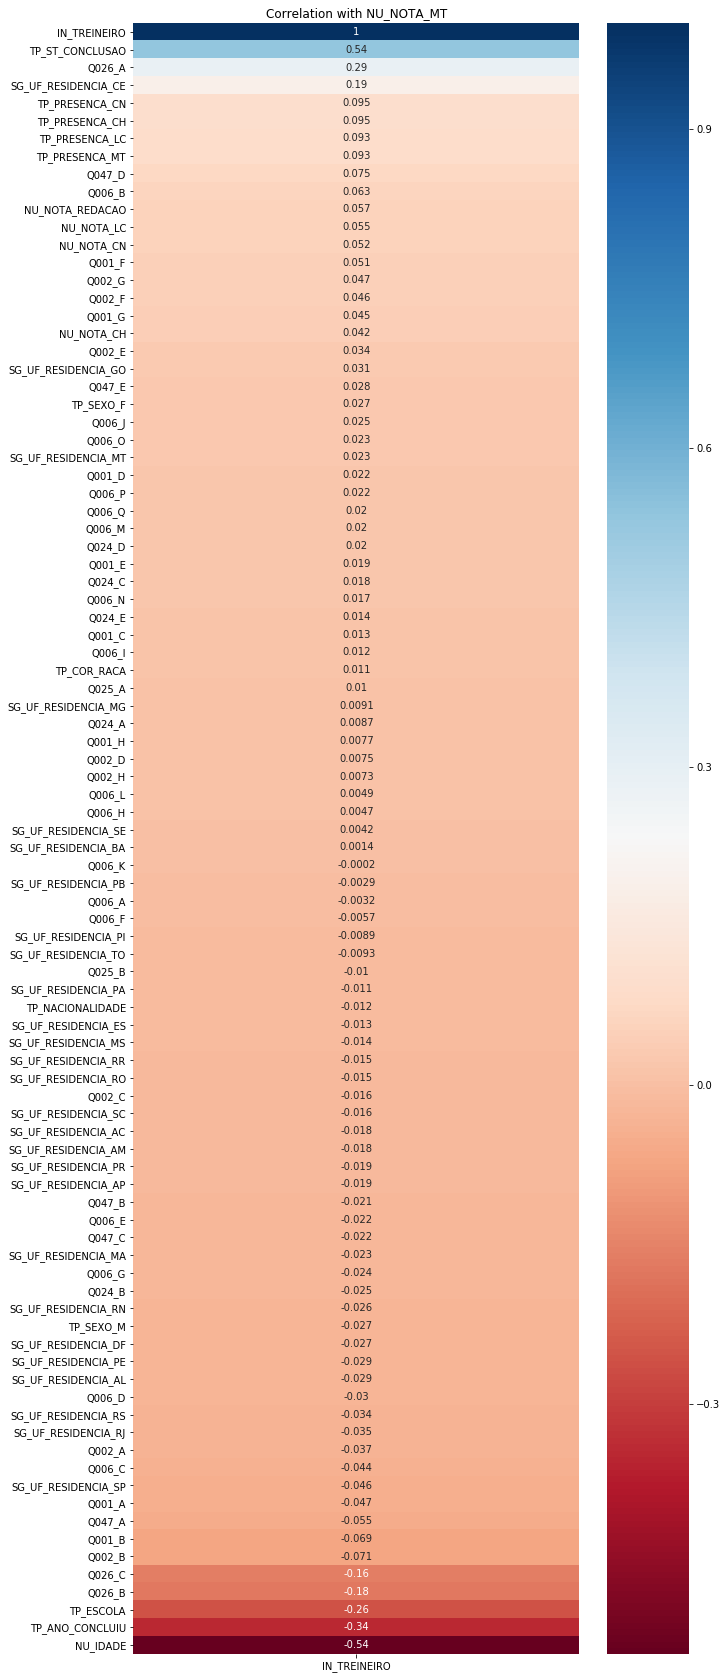

In [11]:
fig , ax = plt.subplots(figsize = (10,30))
ax = sns.heatmap(
    target_treineiro,
    annot = True,
    cmap = 'RdBu'

)
plt.title('Correlation with NU_NOTA_MT')
plt.show()

As we can observe, the main features correlated to the `IN_TREINEIRO` are:

In [12]:
corr_cols = list(corr_values.head(6).index)
corr_cols

['IN_TREINEIRO',
 'TP_ST_CONCLUSAO',
 'NU_IDADE',
 'TP_ANO_CONCLUIU',
 'Q026_A',
 'TP_ESCOLA']

In [13]:
enem_train_selected = enem_train[corr_cols]
corr_cols.remove('IN_TREINEIRO')
enem_test_selected = enem_test[corr_cols]

# Dealing With Unbalanced Sample

Now I a going to check if we have a balanced sample regarding the output of `IN_TREINEIRO` so we can have a reliable model from it.

In [14]:
candidates_training = enem_train_selected['IN_TREINEIRO'].value_counts()
print(f'Candidates for training: {candidates_training[1]} \nOther candidates: {candidates_training[0]}')

Candidates for training: 1783 
Other candidates: 11947


We can see that there is a great imbalance between the two variables, so I am going to do oversampling methods for the candidates training using `SMOTE`.

In [15]:
smote = SMOTENC(categorical_features=[0,2,3,4])
x_train = enem_train_selected.drop(columns = 'IN_TREINEIRO')
y_train = enem_train_selected['IN_TREINEIRO']
x_smote, y_smote = smote.fit_resample(x_train, y_train)
candidates_training = y_smote.value_counts()
print(f'Candidates for training: {candidates_training[1]} \nOther candidates: {candidates_training[0]}')


Candidates for training: 11947 
Other candidates: 11947


## Building and Applying Model

For this analysis, I will compare three models: Random Forest, Logistic Regression and KNeghbors Classifier

### Select Classifier

In [21]:
def classifier_scores (classifierName, classifier, x,y):
    clf = classifier()
    clf.fit(x,y)
    score = clf.score(x, y)
    print(f'The {classifierName} classifier score is: {score}')

In [23]:
classifiers = {"Logistic Regression" : LogisticRegression, "Random Forest" : RandomForestClassifier, "KNeighbors Classifier" : KNeighborsClassifier}
for classifier, clf in classifiers.items():
    classifier_scores(classifier,clf,x_train,y_train)

The Logistic Regression classifier score is: 0.9954843408594319
The Random Forest classifier score is: 0.9970138383102695
The KNeighbors Classifier classifier score is: 0.9970138383102695


Based on the score value, I will choose the KNeighbors classifier.

### KNeighbors

In [18]:
kneighbor_clf = KNeighborsClassifier() 
kneighbor_clf.fit(x_train,y_train)
answer = kneighbor_clf.predict(enem_test_selected)

In [19]:
nu_insc = pd.read_csv('test.csv')['NU_INSCRICAO']
answer_tofile = pd.DataFrame(zip(nu_insc, answer), columns=['NU_INSCRICAO', 'IN_TREINEIRO'])
answer_tofile.to_csv(r'./answer.csv',index=False)